In [223]:
import numpy as np
import random
from pythreejs import *
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Primitive elements

In [224]:
# create an instance of the line segment object
def ray(origin, direction, length, col):
  return Line(geometry=BufferGeometry(attributes={'position': BufferAttribute(array=np.array([origin, length * np.array(direction)]), normalized=False),}),material=LineBasicMaterial(color=col))

In [225]:
# create an instance of the box object
def point(position, col, size):
  return Points(geometry=BufferGeometry(attributes={"position": BufferAttribute(np.array([position]), normalized=False)}),
                material=PointsMaterial(color=col, size=size, sizeAttenuation=False))

In [226]:
# create an instance of the box object
def box(width, height, depth, position, col, col2, rot):
  box_geometry = BoxBufferGeometry(width=width, height=height, depth=depth)

  box_material = MeshPhysicalMaterial(color=col, transparent=True, opacity=0.5)
  box_mesh = Mesh(geometry=box_geometry, material=box_material)
  box_mesh.quaternion = tuple(Rotation.from_euler('xyz', rot, degrees=True).as_quat().tolist())

  wireframe_material = LineBasicMaterial(color=col2)
  wireframe = WireframeGeometry(box_geometry)
  wireframe_mesh = LineSegments(wireframe, wireframe_material)
  wireframe_mesh.quaternion = tuple(Rotation.from_euler('xyz', rot, degrees=True).as_quat().tolist())

  box_group = Group(children=[box_mesh, wireframe_mesh])
  box_group.position = position

  return box_group

# Helper fuctions

In [227]:
# spherical to cartesian
def sph_car(theta, phi, r=1):
  x = r * np.sin(phi) * np.cos(theta)
  y = r * np.sin(phi) * np.sin(theta)
  z = r * np.cos(phi)
  return np.array([x, y, z])

In [228]:
def car_sph(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arccos(z / r)
    theta = np.arctan2(y, x)
    return theta, phi

In [229]:
# entry and exit points for a ray through an axis-aligned box
def intersect_ray_box(ray_origin, ray_direction, box_min, box_max):
    tnear = float('-inf')
    tfar = float('inf')

    for i in range(3):
        if ray_direction[i] == 0:
            if ray_origin[i] < box_min[i] or ray_origin[i] > box_max[i]:
                return None, None
        else:
            t1 = (box_min[i] - ray_origin[i]) / ray_direction[i]
            t2 = (box_max[i] - ray_origin[i]) / ray_direction[i]

            if t1 > t2:
                t1, t2 = t2, t1

            if t1 > tnear:
                tnear = t1

            if t2 < tfar:
                tfar = t2

            if tnear > tfar:
                return None, None

            if tfar < 0:
                return None, None

    return ray_origin + ray_direction * tnear, ray_origin + ray_direction * tfar

In [230]:
# takes two numpy arrays
def angle_between_vectors(a, b):
    return np.arccos(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

I am going to be filling in the mathematically precise functions of theta and phi to replace the rough ones. For all, the only restrictions are that $\text{dir}$, or $\text{sph car}(\theta,\phi)$, is normalized. This can be ignored.

Distance Functions:

Back: $\frac{d}{\cos(\phi)}$

Left (+), Right (-): $\frac{\pm w}{2\sin(\phi)\cos(\theta)}-\frac{o}{\cos(\phi)}$

Top (+), Bottom (-): $\frac{\pm h}{2\sin(\phi)\sin(\theta)}-\frac{o}{\cos(\phi)}$

Their integrals, for future use:

Back: $d\ln|\tan(\phi)+\sec(\phi)|+C$


In [231]:
# my mathematically precise distance piecewise; still gotta get top and bottom and set up the trigger intervals
def dist(side):
  if side == 'back':
    # a pure function in and of itself
    return depth/np.cos(phi)
  elif side == 'right':
    # \frac{-w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([-1,0,0]))))-origin/np.cos(phi)
  elif side == 'left':
    # \frac{w}{2sin(\phi)cos(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return width/(2*np.cos(angle_between_vectors(dir, np.array([1,0,0]))))-origin/np.cos(phi)
  elif side == 'top':
    # \frac{h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,1,0]))))-origin/np.cos(phi)
  elif side == 'bottom':
    # \frac{-h}{2sin(\phi)sin(\theta)}-\frac{o}{cos(\phi)} is equivalent
    return height/(2*np.cos(angle_between_vectors(dir, np.array([0,-1,0]))))-origin/np.cos(phi)
  else:
    return -1

In [232]:
# relationship between enery level and number of photons
def γ_num_by_MeV(MeV):
  return 1/(MeV+0.1)

In [233]:
# relationship between enery level and angle
def MeV_by_φ(MeV):
  return 5/(MeV**0.5+0.5)-1

In [234]:
# selects a random photon energy in the range of interest
def random_energy_level(MeV_range):
  n1 = random.random() * (MeV_range[1] - MeV_range[0]) + MeV_range[0]
  n2 = random.uniform(0,γ_num_by_MeV(MeV_range[0]))

  if n2 > γ_num_by_MeV(n1):
    return -1
  else:
    return n1

In [235]:
# takes a range of MeV we're interested in and outputs a corresponding θ and φ
def dir_from_γ_energy_range(range):
  MeV = random_energy_level(range)
  if MeV > 0:
    return random.uniform(0,2*np.pi), MeV_by_φ(MeV)
  else:
    return -1, -1

In [236]:
# calculate uniform-distribution average distance through target
def average_ray_length_uniform(samples):
    data = np.array([])

    for i in range(samples):
        theta = random.uniform(0,2*np.pi)
        phi = random.random()**0.5 * np.cos(phi_max)
        if theta >= 0:
            dir = sph_car(theta, phi)
            en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
            if en is not None and ex is not None:
                data = np.append(data, np.linalg.norm(en - ex))

    return np.mean(data)

In [237]:
# returns the depth at which γd reaction occurs in range (0,target depth)
def γ_depth(d):
    r = d*random.random()
    fr = 1/(2*r+1)
    r2 = random.random()
    if r2 <= fr:
        return r
    else:
        return γ_depth(d)

In [238]:
# returns the angle at which a neutron is ejected following γd reaction
def n_angle_CM(min,max):
    r = random.uniform(min,max)
    fr = 1/(r**2+1)
    r2 = random.random()
    if r2 <= fr:
        return r
    else:
        return n_angle_CM(min,max)

In [239]:
def n_dir(γ,b,q,origin,depth):
    theta = n_angle_CM(-6,6)
    dir = np.array([γ*q*np.sin(theta)+b*γ*q*np.cos(theta),0,b*γ*q*np.sin(theta)+γ*q*np.cos(theta)])
    collision_depth = γ_depth(depth)
    poc = np.array([0,0,origin+collision_depth])
    return (poc,dir)

In [240]:
def np_momentum(γ,v,c,pγz,md,mp,mn):
    EγCM = γ*pγz*(1-v/c)
    pdCM = -v
    return np.sqrt(mn**4 * EγCM**2 - 2 * mn**4 * EγCM * np.sqrt(md**2 + pdCM**2) + mn**4 * md**2 + mn**4 * pdCM**2 - 2 * mn**2 * mp**2 * EγCM**2 + 4 * mn**2 * mp**2 * EγCM * np.sqrt(md**2 + pdCM**2) - 2 * mn**2 * mp**2 * md**2 - 2 * mn**2 * mp**2 * pdCM**2 - 2 * mn**2 * EγCM**4 + 4 * mn**2 * EγCM**2 * md**2 + 4 * mn**2 * EγCM**2 * pdCM**2 - 2 * mn**2 * md**4 - 4 * mn**2 * md**2 * pdCM**2 - 2 * mn**2 * pdCM**4 + mp**4 * EγCM**2 - 2 * mp**4 * EγCM * np.sqrt(md**2 + pdCM**2) + mp**4 * md**2 + mp**4 * pdCM**2 - 2 * mp**2 * EγCM**4 + 4 * mp**2 * EγCM**2 * md**2 + 4 * mp**2 * EγCM**2 * pdCM**2 - 2 * mp**2 * md**4 - 4 * mp**2 * md**2 * pdCM**2 - 2 * mp**2 * pdCM**4 + EγCM**6 + 2 * EγCM**5 * np.sqrt(md**2 + pdCM**2) - EγCM**4 * md**2 - EγCM**4 * pdCM**2 - 4 * EγCM**3 * md**2 * np.sqrt(md**2 + pdCM**2) - 4 * EγCM**3 * pdCM**2 * np.sqrt(md**2 + pdCM**2) - EγCM**2 * md**4 - 2 * EγCM**2 * md**2 * pdCM**2 - EγCM**2 * pdCM**4 + 4 * EγCM * md**2 * pdCM**2 * np.sqrt(md**2 + pdCM**2) + 2 * EγCM * pdCM**4 * np.sqrt(md**2 + pdCM**2) + 2 * EγCM * md**4 * np.sqrt(md**2 + pdCM**2) + md**6 + 3 * md**4 * pdCM**2 + 3 * md**2 * pdCM**4 + pdCM**6) / (2 * np.sqrt(EγCM**4 - 2 * EγCM**2 * (md**2 + pdCM**2) + md**4 + 2 * md**2 * pdCM**2 + pdCM**4))

# Interface

In [241]:
# parameters (θ is azimuthal, φ is polar)
origin = 10                                                                 # along z: distance from origin
# target dimensions
width = 0.3                                                                 # along x
height = 2.5                                                                # along y
depth = 3.8                                                                 # along z
# detctor dimensions
width_d = 5                                                                 # along x
height_d = 20                                                               # along y
depth_d = 10                                                                # along z
# parameters of the colliding particles
pγz = 400                                                                   # z-momentum of the photon
mp = 938.28                                                                 # mass of the proton
mn = 939.57                                                                 # mass of the neutron
md = 1875.61                                                                # mass of the deuteron
c = 1                                                                       # speed of light normalized
v = pγz/(pγz+md*c)                                                          # velocity of the CM frame
γ = 1/np.sqrt(1-v**2/c**2)                                                  # Lorentz factor
pn = np_momentum(γ,v,c,pγz,md,mp,mn)                                        # momentum of the proton and neutron in CM frame
neutron_path = n_dir(γ,v/c,pn,origin,depth)                                        # tuple point of collision, direction vector
# misc
box_min = np.array([-width / 2, -height / 2, origin])                       # minimum point along target box
box_max = np.array([width / 2, height / 2, depth + origin])                 # maximum point along target box 
phi_max = np.arccos(origin / (np.sqrt(width**2/4+height**2/4+origin**2)))   # maximum polar coordinate along target box

In [265]:
# params for histogram
samples = 100000                                                            # number of rays tried
bins = 100                                                                  # number of bins for successful rays to land in

# Rendering stuff

In [284]:
# histogram
data = np.array([])
phi_values = []
theta_values = []
data_w_misses = np.array([])
phi_values_w = []
theta_values_w = []

for i in range(samples):
    theta, phi = dir_from_γ_energy_range((2.5, 20))
    if theta >= 0:
        dir = sph_car(theta, phi)
        en, ex = intersect_ray_box(np.array([0, 0, 0]), dir, box_min, box_max)
        if en is not None and ex is not None:
            data = np.append(data, np.linalg.norm(en - ex))
            data_w_misses = np.append(data_w_misses, np.linalg.norm(en - ex))
            phi_values.append(phi)
            theta_values.append(theta)
        else:
            data_w_misses = np.append(data_w_misses, 0)
        phi_values_w.append(phi)
        theta_values_w.append(theta)

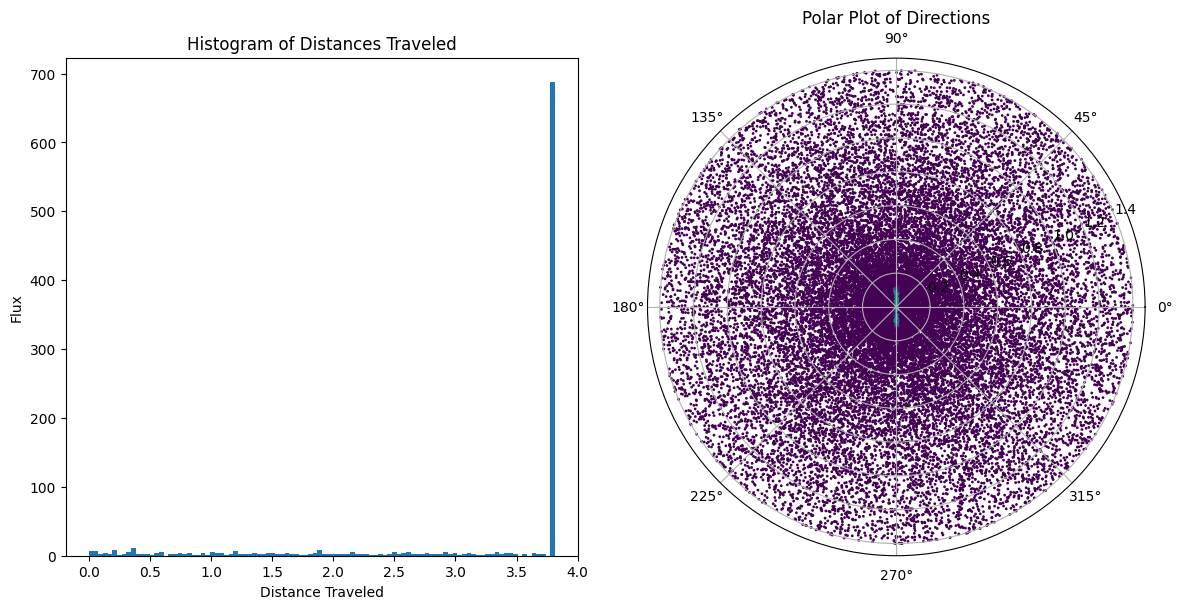

Mean Distance Traveled: 3.1759099971020954


In [285]:
# Plot histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=bins)
plt.xlabel('Distance Traveled')
plt.ylabel('Flux')
plt.title('Histogram of Distances Traveled')

norm = colors.Normalize(vmin=0, vmax=7.3)
cmap = cm.viridis

point_colors = cmap(norm(data_w_misses))

# Plot polar coordinates
plt.subplot(1, 2, 2, projection='polar')
plt.scatter(np.array(theta_values_w), np.array(np.mod(phi_values_w,2*np.pi)), s=1, c=point_colors)
plt.title('Polar Plot of Directions')

plt.tight_layout()
plt.show()

# Print mean of the data
print("Mean Distance Traveled:", np.mean(data))

In [245]:
# UI rendering
target_box = box(width, height, depth, (0, 0, depth / 2 + origin), 'red', '#ff7070', [0,0,0])
print((0, 0, depth / 2 + origin))
d_90 = box(width_d, height_d, depth_d, (-20*100*np.sin(np.deg2rad(90)), 0, depth / 2 + origin - 20*100*np.cos(np.deg2rad(90))), 'green', '#69f069', [0,0,0])        # still need to fix rotation
d_135 = box(width_d, height_d, depth_d, (-20*100*np.sin(np.deg2rad(135)), 0, depth / 2 + origin - 20*100*np.cos(np.deg2rad(135))), '#645cf2', '#9f9af5', [0,0,0])  # still need to fix rotation
d_155 = box(width_d, height_d, depth_d, (-12.8*100*np.sin(np.deg2rad(155)), 0, depth / 2 + origin - 12.8*100*np.cos(np.deg2rad(155))), '#fac516', '#fadc7a', [0,90,0])  # still need to fix rotation

ray1 = ray(np.array([0, 0, 0]), neutron_path[0], 1, 'yellow')
ray2 = ray(neutron_path[0], neutron_path[0]+neutron_path[1], 1, 'white')

origin_point = point([0, 0, 0], 'white', 4)

ah = AxesHelper(size=1)

scene = Scene(children=[target_box, origin_point, ray1, ray2, ah, d_90, d_135, d_155])
scene.background = '#141414'

lights = [
    DirectionalLight(color='white', intensity=3, position=[0, 200, 0]),
    DirectionalLight(color='white', intensity=3, position=[100, 200, 100]),
    DirectionalLight(color='white', intensity=3, position=[-100, -200, -100])
]
for light in lights:
    scene.add(light)

# Create an OrthographicCamera with the correct bounds
camera = PerspectiveCamera(position=[10, 10, 10], up=[0, 1, 0], aspect=2, far=20000, children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

# Display the scene with the OrthographicCamera
display(Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], antialias=True, width=1000, height=500))

(0, 0, 11.9)


Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.5, positio…